In [1]:
# -*- coding: utf-8 -*-
#!/home/seva/anaconda3/envs/cirenv/bin/python python3
print('hello')
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import random as rnd
import math
#import cv2
import time
#%load_ext autoreload
#%autoreload 2
import importlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
#import pandas as pd 

hello


# Random data generation

# GPU enabling

In [2]:
device = "cuda"
#device = "cpu"
print(device)

cuda


# Generation of images

In [3]:
def genbatch(k, imsize, N, n, device, randinit):
    # np.random.seed(0)
    # t.random.manual_seed(0)
    data = t.zeros([N,1,imsize,imsize], dtype=t.float32)
    #print(data.device)
    labels = t.rand((N,k*n))
    labels = labels.to(device)
    #data, labels = data.to(device), labels.to(device), 
    if randinit: 
        data = t.rand([N,1,imsize,imsize])
        data = data.to(device)
    else: 
        data = data.to(device)
        for i in range(N):
            data[i,:,:,:] = ellipses(labels[i,:], k, imsize, device)
    #t.cuda.set_device(device)

    #print(data.device)

        #image from circle generator is saved. first argument is batch iterable,
        #second argument is color iterable, last two are image dimensions
    #labels = t.from_numpy(labels)
    #dividing data into train and test
    testsize = int(N*0.2)
    valsize = int((N-testsize)*0.2)
    testset = [data[:testsize,:,:,:].float(), labels[:testsize,:].float()]
    datar = data[testsize:,:,:,:]
    #print(datar.device)
    labelsr = labels[testsize:,:]
    dataset = [datar[valsize:,:,:,:].float(), datar[:valsize,:,:,:].float(),\
                labelsr[valsize:,:].float(), labelsr[:valsize,:].float()]
    #cross-validation splitting
    # dataset_i = []
    # dataset = []
    #batcha = range(0, N, valsize)
    #for i, n in enumerate(batcha[:-1]):
    #    dataset_i = [datar[n:batcha[i+1],:,:,:].float(), \
    #                (t.cat((datar[:n,:,:,:], datar[batcha[i+1]:,:,:]), 0)).float(), \
    #                labelsr[n:batcha[i+1],:].float(), \
    #                (t.cat((labelsr[:n,:], labelsr[batcha[i+1]:]), 0)).float(),]
    #    dataset.append(dataset_i)
    return(dataset, testset)

In [1]:
def figure_init(imsize, device):
    X = t.arange(0, imsize, 1, dtype=t.float32, requires_grad=True)
    Y = t.arange(0, imsize, 1, dtype=t.float32, requires_grad=True)
    X, Y = t.meshgrid(X, Y)
    #t.cuda.set_device(device)
    X, Y = X.to(device), Y.to(device)
    return(X, Y)
def smoothborder(r, x):
    if len(x) > 4:
        r0 = t.sqrt(x[2]**2+x[3]**2)
        #t.cuda.set_device(device)
        r0 = r0.to(device)
    else:
        r0 = x[2]
    I = (r <= r0)
    a = 1
    c = 4
    I2 = (1+a*np.exp(c))/(1+a*t.exp(c*r/r0))
    I = I + (r > r0) * I2
    return(I)
def ellipses(x, k, imsize, device):
    X, Y = figure_init(imsize, device)
    I = t.zeros([imsize,imsize], dtype=t.float32, requires_grad=True)
    R = t.zeros([imsize,imsize], dtype=t.float32, requires_grad=True)
    #t.cuda.set_device(device)
    I, R = I.to(device), R.to(device)

    for i in range(int(len(x)/k)):
        if k == 3:
            r = t.sqrt(((X-x[k*i]*imsize)**2 + (Y-x[k*i+1]*imsize)**2))/imsize
        if k == 4:
            r = t.sqrt((((X-x[k*i]*imsize)/x[k*i+2])**2 + \
            ((Y-x[k*i+1]*imsize)/x[k*i+3])**2))/imsize
        #t.cuda.set_device(device)
        r = r.to(device)
        I = I + smoothborder(r, x[k*i:k*(i+1)])
    R = (I>=1) + (I<1)*I
    return(R)

In [5]:
#%run -i architecture

# Network architectures 

In [6]:
class DNet(t.nn.Module):
    def __init__(self, C_in, D_out, imsize, layers, dop):
        #super(DNet, self).__init__()
        super().__init__()
        self.linear1 = t.nn.Linear(imsize*imsize*C_in, layers[0])
        self.linear2 = t.nn.Linear(layers[0],layers[1])
        self.linear3 = t.nn.Linear(layers[1],layers[2])
        self.linear4 = t.nn.Linear(layers[2], D_out)
        self.do = t.nn.Dropout(p=dop)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        #print(x.shape)
        print(len(t.nonzero(x, as_tuple = False)))
        x = self.do(F.leaky_relu(self.linear1(x).clamp(min=0)))
        
        #len(np.where( q < 0.1))
        
        x = self.do(F.leaky_relu(self.linear2(x)))

        #print(x.shape)
        #print(t.mean(x))
        x = self.do(F.relu(self.linear3(x)))
        #x = F.relu(self.linear4(x))
        x = self.do(self.linear4(x))
        return x
class CNet(t.nn.Module):
    def __init__(self, C_in, D_out):
        super(CNet, self).__init__()
        self.conv0 = nn.Conv2d(C_in, 6, 5)
        self.conv1 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.linear0 = t.nn.Linear(16*47*47, 1000)
        self.linear1 = t.nn.Linear(1000, D_out)

    def forward(self, x):
        x = self.pool(F.relu(self.conv0(x)))
        print(t.mean(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
        x = F.relu(self.linear0(x))
        x = F.relu(self.linear1(x))
        #x = self.linear1(x)
        return x

In [7]:
nnarchitectures = { 'DNet' : DNet, 
                    'CNet' : CNet}

In [8]:
def ntime(fseconds):
    #millis = int(millis)
    seconds=(fseconds)%60
    seconds = int(seconds)
    minutes=(fseconds/(60))%60
    minutes = int(minutes)
    hours=(fseconds/(60*60))%24

    print ("%d:%d:%d" % (hours, minutes, seconds))

# Network training

In [9]:
def train(data, lr, epochs, layers, dop, imsize, model = None, modelname = 'DNet', ltype = 'supervised') :
    xtrain = data[0] #first counter is batch counter, second is data counter
    xval = data[1]
    ytrain = data[2]
    yval = data[3]
    op = data[3].shape[1] #output parameters
    N = data[0].shape[0] #batch size
    if model is None:
        model = nnarchitectures[modelname](1, op, imsize, layers, dop)
        model.to(device)
    # Construct our loss function and an Optimizer. The call to model.parameters()
    # in the SGD constructor will contain the learnable parameters of the 
    # modules which are members of the model.
    criterion = t.nn.MSELoss(reduction='mean')
    #criterion = t.nn.L1Loss()
    optimizer = t.optim.Adam(model.parameters(), lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    #optimizer = t.optim.Adam(model.parameters(), lr)
   
    loss = []
    lossa = np.zeros([2, epochs])
    #tl = []
    for tm in range(epochs):
        #start = time.time()
        print(tm)
        xtrain = xtrain.detach() #xtrain contains images of the circle
        y_pred = model(xtrain) #y_pred consists of coordinates of the circle center and its radius
        if ltype == 'supervised': 
            # Forward pass: Compute predicted y by passing x to the model
            #calculating loss between predicted parameters and parameters which were used for generation
            loss = criterion(y_pred, ytrain)
            lossa[0][tm] = loss.item() #the first number in the loss is a training loss
            #updating list with losses 
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lossa[1][tm] = criterion(model(xval), yval).item() #the second number in the loss is a validation loss 
        else: 
            x_pred = t.zeros([N,1,imsize,imsize])
            for i in range(N):
                # Generating circles with inferred parameters y_pred.
                #print(y_pred)
                x_pred[i,0,:,:] = ellipses(y_pred, k, imsize, device)
            # Compute and print loss
            # Compare generated image with the input image, finding per-pixel distance between two images
            loss = criterion(x_pred, xtrain)
            #print(loss.item())
            lossa[0][tm] = loss.item() #the first number in the loss is a training loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lossa[1][tm] = criterion(model(xval), yval).item() #the second number in the loss is a validation loss 
        #end = time.time()
        #tl.append(end-start)
        #if tm % 10 == 9:
        #ntime(sum(tl) / len(tl)*epochs - sum(tl))
    return model, lossa

## Run the training with the different learning rate 

In [10]:
np.random.seed(0)
t.manual_seed(0)
rnd.seed(0)
t.backends.cudnn.deterministic=True

In [11]:
k = 4
n = 3
imsize = 200
bs = 100

In [12]:
dataset, _ = genbatch(k, imsize, bs, n, device, randinit = 'True')
dataset[0].shape

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
datarnd = t.tensor(np.random.uniform(low = 0, high = 1.0, size = [bs, 1, imsize, imsize])).float()
datarnd = datarnd.to(device)
datarnd.shape
#print(datarnd.shape)

In [ ]:
#%run -i architecture
#lrrange = np.linspace(2.5e-5, 7.5e-5, 3) #test different learning rates (min, max, number of points)
lrrange = np.linspace(5e-5, 5e-5, 1) #test different learning rates (min, max, number of points)
epochs = 20
#imsize = 100
lossl = np.zeros([len(lrrange), 2, epochs])
for i, lr in enumerate(lrrange):
    model = None
    _, lossa = train(dataset, lr, epochs, imsize, ltype = 'supervised')
    #ntime(len(lrrange)*sum(tl) / len(tl)*epochs - sum(tl))
    lossl[i] = lossa

### Model test

In [13]:
# print(model(testset[0]))
# loss = criterion(model(testset[0]), testset[1])
# print(loss.item()/(N-b))

### Plotting the loss in dependence on epoch

NameError: name 'lossl' is not defined

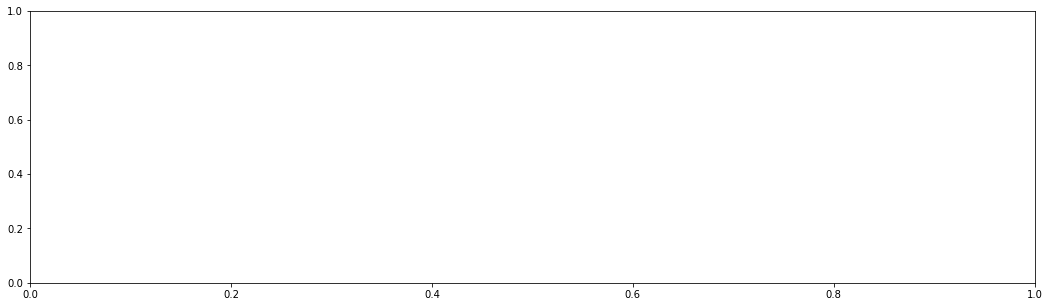

In [14]:
plt.rcParams["figure.figsize"] = (18,5)
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
colors = ['red', 'green']
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
#axes.set_ylim([0,10000])
labels_text = ['training', 'validation']
for par in range(len(lossl)):
    for trt in range(2):
        plt.plot(np.arange(epochs), lossl[par][trt][:], label=labels_text[trt], \
                 color = colors[trt], linestyle = linestyles[par], linewidth=3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0., fontsize = 24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#axes.legend([1, 2, 3], ("0-10", "10-100"))
plt.autoscale(enable=True, axis='both', tight=None)
# font = fm.FontProperties(#family='Comic Sans MS',
#                                    #weight='bold',
#                                    style='normal', size=24)
# axes.legend(prop=font)
#ax.set_ylabel('Example', fontsize=40)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('MSE Loss', fontsize=24)
plt.savefig('foo.png', bbox_inches='tight')
plt.show()

### Detecting a training line with a minimal validation loss trend and calculating corresponing lr

In [15]:
import operator
losval = np.array(losslv)
#print(np.amin(losval, axis=0)) 
result = np.where(losval == np.amin(losval, axis=0))
#print('Tuple of arrays returned : ', result)
#print('List of coordinates of minimum value in Numpy array : ')
# zip the 2 arrays to get the exact coordinates
listOfCordinates = list(zip(result[0], result[1]))
# travese over the list of cordinates
d = dict()
for cord in listOfCordinates:
    #print(cord)
    c = cord[0]
    d[c] = d.get(c,0) + 1
#print(d)
print(max(d.items(), key=operator.itemgetter(1))[0])
print("{:.2e}".format(lrrange[int(max(d.items(), key=operator.itemgetter(1))[0])]))


NameError: name 'losslv' is not defined

## Optimizing data size 

In [16]:
np.random.seed(0)
t.random.manual_seed(0)

In [17]:
#epochs, bn, bs = (7,)*3
epochs = 100
lr = 5e-5
imsize = 100
bn = 10
bs = 100
k = 4
n = 3
layers = [1000, 200, 100]
dop = 0
randinit = 1

In [18]:
lossl = np.zeros([2, 1])
lossl = np.delete(lossl, 0, 1)
modeli = None
tl = []
#os.environ["CUDA_VISIBLE_DEVICES"]=""

In [19]:
#cuda
#drange = np.linspace(1e+4, 1e+4, 4, dtype = int)
starta = time.time()
for i in range(bn):
    start = time.time()
    #print(i)
    #idata, _ = genbatch(int(1e+3), n, 'one_circle_gen', imsize)
    #print(i)
    idata, _ = genbatch(k, imsize, bs, n, device, randinit)
#     idata = t.tensor(np.random.uniform(low = 0, high = 1.0, size = [bs, 1, imsize, imsize])).float()
#     idata = idata.to(device)
    #def train(dataset, lr, epochs, layers, dop, imsize, model = None, modelname = 'DNet', ltype = 'supervised') :
    modeli, lossc = train(idata, lr, epochs, layers, dop, imsize, modelname = 'DNet',  model = modeli)
    #lossl.append(lossa)
    lossl = np.concatenate((lossl, lossc), axis=1)
    #print(lossl.shape[1])
    end = time.time()
    tl.append(end-start)
#lossl = np.delete(lossl, 0, 1)
    #start = time.time()
#     tl.append(end-start)
    ntime(sum(tl) / len(tl)*bn - sum(tl))
enda = time.time()
timelapse = enda - starta

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

ValueError: x and y must have same first dimension, but have shapes (1000,) and (0,)

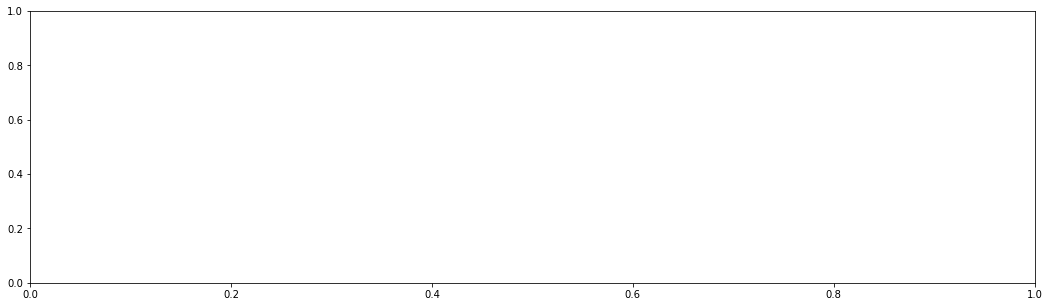

In [20]:
plt.rcParams["figure.figsize"] = (18,5)
#linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
colors = ['red', 'green']
axes = plt.gca()
labels_text = ['training', 'validation']
for trt in range(len(labels_text)):
    plt.plot(np.arange(epochs*bn), lossl[trt][:], label=labels_text[trt], \
             color = colors[trt], linewidth=3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0., fontsize = 24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.autoscale(enable=True, axis='both', tight=None)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('MSE Loss', fontsize=24)
#+n+bn+bs+epochs+lr+imgsize+layers+dop+
plt.savefig('k'+str(k)+'_'+'n'+str(n)+'_'+'imsize'+str(imsize)+'_'+'bn'+str(bn)+','+'bs'+str(bs)+'_'+\
            'epochs'+str(epochs)+'_'+'layers'+str(layers)+'_'+'lr'+str(lr)+'_'+'etime'+\
            str(int(timelapse)) + '_' + 'noisein' + str(randinit) +'.png', bbox_inches='tight')
plt.show()

# Unsupervised model. NN infers parameters of a object, then conducts it to the image generator and calculate loss between generated image and input image

In [ ]:
%run -i 'architecture.py'
# Choose NN model architecture, criterion for loss calculation and optimizer
model = CNet(1, ytrain.shape[1])
#criterion = t.nn.MSELoss(reduction='sum')
criterion = t.nn.MSELoss()
optimizer = t.optim.SGD(model.parameters(), lr=1e-5)
from circle_generator import *
lossl = []
for t in range(100):
    # Forward pass: Compute predicted y by passing x to the model
    xtrain = xtrain.detach() #xtrain is an image with a single circle with smooth edges
    y_pred = model(xtrain) #y_pred contains coordiantes of circle centre and its radius
    x_pred = t.zeros([b,1,imsize,imsize])
    for i in range(b):
        # Generating circles with inferred parameters y_pred.
        x_pred[i,0,:,:] = one_circle_gen(y_pred[i])
    # Compute and print loss
    # Compare generated image with the input image, finding per-pixel distance between two images
    loss = criterion(x_pred, xtrain)
    lossl.append(loss.item())
    #print(y_pred[0])
    #print(y_pred.grad_fn)
    #print(t.sum((x_pred - xtrain)))
    #print(t.sum(y_pred))


    # Print loss every 10 epochs
    print(y_pred[0])
    if t % 10 == 9:
        print(t, loss.item())
        #print(y_pred[0])
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
y_pred[0]

In [ ]:
plt.imshow(x_pred[0,0,:,:].detach().numpy())

In [ ]:
print(y_pred)

In [ ]:
plt.imshow(xtrain[9,0,:,:].detach().numpy())

In [ ]:
plt.imshow((x_pred - xtrain)[30,0,:,:].detach().numpy())

In [ ]:
t.sum((x_pred - xtrain))

In [ ]:
t.sum((x_pred))

In [ ]:
criterion(x_pred[i,0,:,:], xtrain[i,0,:,:])

In [ ]:
print(y_pred)

In [ ]:
a = t.tensor([1, 2, 3])
b = t.tensor([4, 5, 6])
x = t.cat((a, b), 0)
print(x)